# Value Function Approximation

Notes from this [lecture](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)

Slides are [here](https://davidstarsilver.wordpress.com/wp-content/uploads/2025/04/lecture-6-value-function-approximation-.pdf).



- So far we looked at the value function as a look up table
- There are too many states / actions
- Solution, approximate the value function, estimate v everywhere


$$
\hat{v}(s, \mathbf{w}) \approx v_{\pi}(s)\\
\hat{q}(s, a, \mathbf{w}) \approx q_{\pi}(s, a)
$$

- We could use any function approximater, examples: Neural Networks, decision trees, linear combinations of features.
- The training data need to be non-stationary, non-iid data
- could use gradient descent

## Initial setup

We'll use [`gymnasium`](https://gymnasium.farama.org/) for creating enviroments that we could use to test various algorithms.

Here is some boilerplate code that helps us train any policy:

## Mountain Car Example

Let's try playing around with the mountain car example.

See documation for this example here https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/

Here we approximate the value function as linear mapping from the state:

$$
Q(s, a) = W[a]^T \cdot s
$$


### Metrics we will collect in order to compare the performance of different approaches:
1. Quality of the final policy, how many time steps it takes to reach the goal
2. How many episodes does it take to train the policy
3. How well does the policy deal with peturbations in the initial conditions.


Let's try that with the mountain car example:

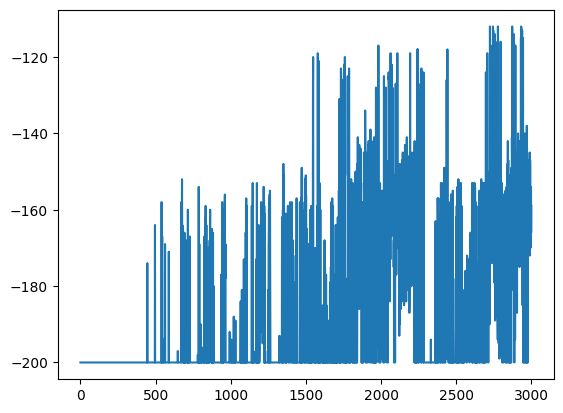

In [7]:
import mountain_car_utils
import importlib
importlib.reload(mountain_car_utils)
from mountain_car_utils import *


import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy


# ----------------------
# Hyperparameters
# ----------------------
alpha = 0.1          # learning rate
gamma = 0.99          # discount
epsilon = 1.0         # exploration
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 3000

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")

res_p = 0.1
res_v = 0.01

state_low = env.observation_space.low
state_high = env.observation_space.high
n_actions = env.action_space.n

p_range =  state_high[0] - state_low[0] 
v_range =  state_high[1] - state_low[1] 

n_p = int(p_range / res_p) + 1
n_v = int(v_range / res_v) + 1

Q = np.zeros(shape=(n_p * n_v, n_actions))

def Q_index(state):
    index_p = int((state[0] - state_low[0]) / res_p)
    index_v = int((state[1] - state_low[1]) / res_v)
    return index_p * (n_v) + index_v


# Q[Q_index([state_high[0], state_high[1]], 2)] = 1;

def Q_values(s):
    """Return Q(s, :) for all actions."""
    return Q[Q_index(s)]

def choose_action(state, epsilon):
    """Epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(state))

def update_w(td_error, state, action):
    Q[Q_index(state)][action] += alpha * td_error

reward_history = train_mountain_car(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()
plt.plot(reward_history)

In [74]:
import gymnasium as gym
import numpy as np
import imageio.v3 as iio


def render_policy(Q_values, video_name):

    frames = []

    render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

    state, info = render_env.reset()
    done = False

    def select_action(state):
        return np.argmax(Q_values(state))

    while not done:
        # Greedy action using your linear policy (replace with your function)
        action = select_action(state)

        next_state, reward, terminated, truncated, info = render_env.step(action)
        done = terminated or truncated

        frame = render_env.render()   # RGB array frame
        frames.append(frame)

        state = next_state

    render_env.close()


    # Save frames to MP4 using imageio
    iio.imwrite(
        video_name,
        frames,
        fps=30,
        codec="libx264"
    )



render_policy(Q_values, "mountain_car_tabular.mp4")
print(f"Saved to {video_name}")
from IPython.display import Video
Video("mountain_car_tabular.mp4", embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to cartpole_tabular.mp4


In [85]:
# Tile coding parameters
num_tilings = 8      # number of overlapping tilings
tiles_per_dim = 8    # tiles along each dimension

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")
state_low = env.observation_space.low
state_high = env.observation_space.high
n_actions = env.action_space.n

# ----------------------
# Tile coding setup
# ----------------------
def tile_encode(state):
    """Return a binary feature vector using multiple tilings."""
    features = np.zeros(num_tilings * tiles_per_dim * tiles_per_dim)
    for tiling in range(num_tilings):
        # Compute offsets
        offsets = (tiling / num_tilings) * (state_high - state_low) / tiles_per_dim
        coords = ((state - state_low + offsets) * tiles_per_dim / (state_high - state_low)).astype(int)
        coords = np.clip(coords, 0, tiles_per_dim - 1)
        index = tiling * tiles_per_dim * tiles_per_dim + coords[0] * tiles_per_dim + coords[1]
        features[index] = 1
    return features

num_features = num_tilings * tiles_per_dim * tiles_per_dim

# ----------------------
# Linear weights: one vector per action
# ----------------------
W = np.zeros((n_actions, num_features))

# ----------------------
# Q function
# ----------------------
def Q_values(s):
    features = tile_encode(s)
    return W @ features

# ----------------------
# Epsilon-greedy action
# ----------------------
def choose_action(s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(s))

def update_w(td_error, state, action):
    # TD update
    features = tile_encode(state)
    W[action] += alpha * td_error * features
    

[[-4.68116737 -4.9059904  -5.47973363 ... -3.55494628 -1.78553502
  -0.95730505]
 [-4.52882036 -5.34231276 -5.72204489 ... -1.8216197  -2.24617618
  -1.7484784 ]
 [-4.1228593  -5.67757371 -4.87371314 ... -3.27193173 -0.41030111
  -0.38990922]]


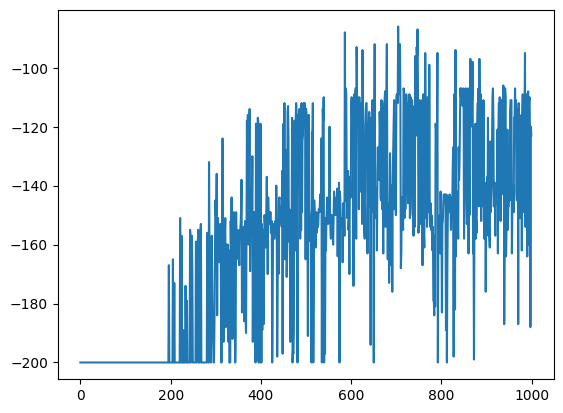

In [86]:
# ----------------------
# Hyperparameters
# ----------------------
alpha = 0.05          # learning rate
gamma = 0.99          # discount
epsilon = 1.0         # exploration
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 1000


reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()

print(W)
plt.plot(reward_history)

In [87]:
render_policy(Q_values, "mountain_car_cmac.mp4")
print(f"Saved to {video_name}")
from IPython.display import Video
Video("mountain_car_cmac.mp4", embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to cartpole_tabular.mp4


## DQN Example


In [104]:
import mountain_car_dqn
import importlib
importlib.reload(mountain_car_dqn)
from mountain_car_dqn import *  # Re-import everything to reflect changes

In [107]:
mountaincar = MountainCarDQL(h1_nodes=100, replay_memory_size=5000)
mountaincar.train(1000, render=False)

Best rewards so far: -4941.0
Episode 1 Epsilon 0.999
Swapped networks
Best rewards so far: -4813.0
Episode 39 Epsilon 0.961
Swapped networks
Best rewards so far: -3359.0
Episode 133 Epsilon 0.867
Swapped networks


### Experiment 1 
- don't digitize the state - converged but didn't reach a working policy
### Experiment 2 
don't digitize the state with normalization - convergance at all
### Experiment 3
normalize the state, and increase the number of hidden nodes to 30 from 10 - converged much better - best reward reached - -159

Best rewards so far: -1000.0
Best rewards so far: -958.0
Best rewards so far: -903.0
Best rewards so far: -786.0
Episode 1000 Epsilon 0.800000000000022
Best rewards so far: -669.0
Best rewards so far: -607.0
Best rewards so far: -471.0
Episode 2000 Epsilon 0.600000000000044
Best rewards so far: -466.0
Episode 3000 Epsilon 0.4000000000000661
Best rewards so far: -436.0
Episode 4000 Epsilon 0.20000000000008117
Best rewards so far: -175.0
Best rewards so far: -159.0



In [109]:
mountaincar = MountainCarDQL(h1_nodes=100)
mountaincar.test(10, "/app/knowledge_compendium/machine_learning/reinforcement_learning/mountaincar_dql.pt", "experiment6.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [1]:
from IPython.display import Video
Video("experiment6.mp4", embed=True)